## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
import datetime
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, FunctionTransformer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResults
from tqdm.notebook import tqdm
from matplotlib.lines import Line2D

In [3]:
def human_format(num):
  """Convert a number to a human readable version, e.g. 10M for 10,000,000."""
  if num == 0:
    return '0'
  letters = ["", "K", "M", "B", "T"]
  scale = math.floor(round(math.log(abs(num), 10)) / 3)
  # Convert to string: truncate to scale, remove trailing zeros and decimal points
  num = float('{:.3g}'.format(num)) / 10**(3*scale)
  num = str(num).rstrip('0').rstrip('.')
  # Append scale letter
  num += letters[scale]
  return num

def mpl_human_format(x, pos):
  if pos is not None:
    return human_format(x)

def make_axes_human_readable(ax, axis="y"):
  if axis.lower() == 'x':
    axisvar = ax.xaxis
  elif axis.lower() == 'y':
    axisvar = ax.yaxis
  else:
    raise("Must specify axis as either 'x' or 'y'")

  axisvar.set_major_formatter(matplotlib.ticker.FuncFormatter(mpl_human_format))
  return ax

## Prepare data

In [6]:
# Load the electricity usage data
NUM_CLUSTERS = 4

cluster_dfs = list()

for i in range(1, NUM_CLUSTERS + 1):
    df = pd.concat([
        pd.read_parquet(f'dataset/cluster_{i}/training.parquet'),
        pd.read_parquet(f'dataset/cluster_{i}/validation.parquet'),
        pd.read_parquet(f'dataset/cluster_{i}/test.parquet'),
    ], axis=1).T
    df.index = pd.to_datetime(df.index)
    df.index.name = 'date'
    df = df.sort_index().asfreq('D')
    cluster_dfs.append(df)

In [8]:
explanatory_variables_df = pd.read_parquet('dataset/combined_explanatory_variables/explanatory_variables.parquet')
explanatory_variables_df.index = pd.to_datetime(explanatory_variables_df.index)
explanatory_variables_df = explanatory_variables_df.sort_index().asfreq('D')
explanatory_variables_df.head()

,heating_degree_days,cooling_degree_days,precip,precipprob,is_holiday,sunlight_length_hours,is_weekend
date,,,,,,,
2012-01-01,6.578559,0.0,0.000,0.0,0,10.0,1
2012-01-02,6.659918,0.0,0.111,1.0,0,10.0,0
2012-01-03,7.977833,0.0,0.000,0.0,0,10.0,0
2012-01-04,6.335269,0.0,0.000,0.0,0,10.0,0
2012-01-05,7.437771,0.0,0.000,0.0,0,10.0,0


## Import trained models

In [11]:
cluster_models = [
    SARIMAXResults.load(f'models/sarimax/cluster{i}/small_model.pickle')
    for i in range(1, NUM_CLUSTERS + 1)
]

FileNotFoundError: [Errno 2] No such file or directory: 'models/sarimax/cluster1/small_model.pickle'

## Helper functions

In [8]:
def get_customer_predictions_(customer_model: SARIMAXResults,
                              scaled_test_data: pd.Series,
                              exog_test_data: pd.DataFrame,
                              window_size_days: int = 7) -> pd.DataFrame:
    assert len(scaled_test_data.index) == len(exog_test_data.index)
    assert window_size_days >= 1
    scaled_test_data = scaled_test_data.sort_index()
    exog_test_data = exog_test_data.sort_index()
    assert (scaled_test_data.index == exog_test_data.index).all()
    total_num_forecast_days = len(scaled_test_data)
    forecast_results = np.full((len(scaled_test_data.index), window_size_days), np.nan)
    series_name = customer_model.model.data.orig_endog.name
    for i in tqdm(range(total_num_forecast_days), desc=series_name, position=2, leave=False):
        # Forecast the next window
        forcast_len_days = min(total_num_forecast_days - i, window_size_days)
        forecast = customer_model.forecast(forcast_len_days,
                                           exog=exog_test_data[i:forcast_len_days+i])
        np.fill_diagonal(forecast_results[i:i+forcast_len_days,:forcast_len_days],
                         forecast)
        # Update the model with the new observation
        new_observed_date, new_observed_value = scaled_test_data.index[i], scaled_test_data.iloc[i]
        new_observed_series = pd.Series(
            [new_observed_value],
            index=[new_observed_date],
            name=series_name,
        ).asfreq('D')
        new_observed_exog = exog_test_data.loc[new_observed_series.index]
        customer_model = customer_model.extend(
            new_observed_series,
            exog=new_observed_exog,
        )
    forecast_results_df = pd.DataFrame(
        forecast_results,
        index=scaled_test_data.index,
        columns=range(1, window_size_days + 1)
    )
    return forecast_results_df


def calculate_mape_(forecast: np.ndarray, test_data: np.ndarray) -> float:
    non_na_mask = ~np.isnan(forecast) & ~np.isnan(test_data)
    forecast_filtered = forecast[non_na_mask]
    test_data_filtered = test_data[non_na_mask]
    return np.mean(np.abs((forecast_filtered - test_data_filtered) / test_data_filtered))


def calculate_mape(forecast_results_df: pd.DataFrame,
                   test_data: pd.Series) -> pd.DataFrame:
    assert (forecast_results_df.index == test_data.index).all()
    mape_df = forecast_results_df.apply(
        lambda column: calculate_mape_(column, test_data.to_numpy()),
        axis=0,
        raw=True,
    )
    return mape_df


def get_customer_predictions(cluster_model: SARIMAXResults,
                             training_data: pd.Series,
                             exog_training_data: pd.DataFrame,
                             test_data: pd.Series,
                             exog_test_data: pd.DataFrame,
                             window_size_days: int = 7) -> pd.DataFrame:
    # Scale down data
    scaler = StandardScaler()
    
    boxcox_training_data, lam = boxcox(training_data)
    scaled_training_data = pd.Series(
        scaler.fit_transform(boxcox_training_data.reshape(-1,1)).flatten(),
        index=training_data.index,
        name=training_data.name,
    )
    
    boxcox_test_data = boxcox(test_data, lmbda=lam)
    scaled_test_data = pd.Series(
        scaler.transform(boxcox_test_data.reshape(-1,1)).flatten(),
        index=test_data.index,
        name=test_data.name,
    )

    # Fit cluster model on customer data
    customer_model = cluster_model.apply(scaled_training_data,
                                         exog=exog_training_data,
                                         refit=False)

    # Get the predictions
    forecast_results_df = get_customer_predictions_(customer_model,
                                                    scaled_test_data,
                                                    exog_test_data,
                                                    window_size_days)

    # Scale up predictions
    forecast_results_df = forecast_results_df.apply(
        lambda column: inv_boxcox(scaler.inverse_transform(column.reshape(-1,1)).flatten(), lam),
        axis=0,
        raw=True
    )
    
    return forecast_results_df


def get_customer_predictions_and_mape(cluster_model: SARIMAXResults,
                                      training_data: pd.Series,
                                      exog_training_data: pd.DataFrame,
                                      test_data: pd.Series,
                                      exog_test_data: pd.DataFrame,
                                      window_size_days: int = 7) -> tuple[pd.DataFrame, pd.Series]:
    forecast_results_df = get_customer_predictions(cluster_model,
                                                   training_data,
                                                   exog_training_data,
                                                   test_data,
                                                   exog_test_data,
                                                   window_size_days)
    mape = calculate_mape(forecast_results_df, test_data)

    return forecast_results_df, mape


def get_cluster_predictions_and_mape(cluster_model: SARIMAXResults,
                                     cluster_df: pd.DataFrame,
                                     training_data_cutoff_date: datetime.datetime,
                                     explanatory_variables_df: pd.DataFrame,
                                     window_size_days: int = 7) -> tuple[pd.DataFrame, pd.DataFrame]:
    exog_var_names = [var_name for var_name in explanatory_variables_df.columns if var_name in cluster_model.param_names]
    exog_data = explanatory_variables_df[exog_var_names]

    training_data_mask = cluster_df.index < training_data_cutoff_date
    training_data = cluster_df[training_data_mask].sort_index().asfreq('D')
    test_data = cluster_df[~training_data_mask].sort_index().asfreq('D')

    exog_training_data = exog_data.loc[training_data.index].asfreq('D')
    exog_test_data = exog_data.loc[test_data.index].asfreq('D')

    customer_forecast_dfs = list()
    customer_mapes = list()
    
    customers = cluster_df.columns
    for customer in tqdm(customers, desc='Customers', position=1, leave=False):
        forecast_results_df, mape = get_customer_predictions_and_mape(cluster_model,
                                                                      training_data[customer],
                                                                      exog_training_data,
                                                                      test_data[customer],
                                                                      exog_test_data,
                                                                      window_size_days)
        forecast_results_df['customer'] = customer
        mape.name = customer

        customer_forecast_dfs.append(forecast_results_df)
        customer_mapes.append(mape)

    customer_forecasts_df = (pd.concat(customer_forecast_dfs, axis=0)
                             .reset_index()
                             .set_index(['customer', 'date']))
    customer_mapes_df = pd.concat(customer_mapes, axis=1).T
    customer_mapes_df.index.name = 'customer'
    return customer_forecasts_df, customer_mapes_df


def get_all_predictions_and_mape(cluster_models: list[SARIMAXResults],
                                 cluster_dfs: list[pd.DataFrame],
                                 training_data_cutoff_date: datetime.datetime,
                                 explanatory_variables_df: pd.DataFrame,
                                 window_size_days: int = 7) -> tuple[pd.DataFrame, pd.DataFrame]:
    cluster_forecast_dfs = list()
    cluster_mape_dfs = list()

    for i, (cluster_model, cluster_df) in tqdm(list(enumerate(zip(cluster_models, cluster_dfs), start=1)), desc='Clusters', position=0, leave=True):
        customer_forecasts_df, customer_mapes_df = get_cluster_predictions_and_mape(cluster_model,
                                                                                    cluster_df,
                                                                                    training_data_cutoff_date,
                                                                                    explanatory_variables_df,
                                                                                    window_size_days)
        customer_forecasts_df['cluster'] = i
        customer_mapes_df['cluster'] = i

        cluster_forecast_dfs.append(customer_forecasts_df)
        cluster_mape_dfs.append(customer_mapes_df)

    cluster_forecasts_df = (pd.concat(cluster_forecast_dfs, axis=0)
                             .reset_index()
                             .set_index(['cluster', 'customer', 'date']))
    cluster_mapes_df = (pd.concat(cluster_mape_dfs, axis=0)
                        .reset_index()
                        .set_index(['cluster', 'customer']))

    return cluster_forecasts_df, cluster_mapes_df

## Evaluate models

In [9]:
forescasts_df, mapes_df = get_all_predictions_and_mape(cluster_models,
                                                       cluster_dfs,
                                                       pd.to_datetime('2014-01-01'),
                                                       explanatory_variables_df)

Clusters:   0%|          | 0/4 [00:00<?, ?it/s]

Customers:   0%|          | 0/179 [00:00<?, ?it/s]

MT_091:   0%|          | 0/365 [00:00<?, ?it/s]

MT_100:   0%|          | 0/365 [00:00<?, ?it/s]

MT_101:   0%|          | 0/365 [00:00<?, ?it/s]

MT_104:   0%|          | 0/365 [00:00<?, ?it/s]

MT_137:   0%|          | 0/365 [00:00<?, ?it/s]

MT_139:   0%|          | 0/365 [00:00<?, ?it/s]

MT_145:   0%|          | 0/365 [00:00<?, ?it/s]

MT_147:   0%|          | 0/365 [00:00<?, ?it/s]

MT_166:   0%|          | 0/365 [00:00<?, ?it/s]

MT_168:   0%|          | 0/365 [00:00<?, ?it/s]

MT_175:   0%|          | 0/365 [00:00<?, ?it/s]

MT_180:   0%|          | 0/365 [00:00<?, ?it/s]

MT_182:   0%|          | 0/365 [00:00<?, ?it/s]

MT_190:   0%|          | 0/365 [00:00<?, ?it/s]

MT_193:   0%|          | 0/365 [00:00<?, ?it/s]

MT_194:   0%|          | 0/365 [00:00<?, ?it/s]

MT_195:   0%|          | 0/365 [00:00<?, ?it/s]

MT_200:   0%|          | 0/365 [00:00<?, ?it/s]

MT_204:   0%|          | 0/365 [00:00<?, ?it/s]

MT_210:   0%|          | 0/365 [00:00<?, ?it/s]

MT_212:   0%|          | 0/365 [00:00<?, ?it/s]

MT_213:   0%|          | 0/365 [00:00<?, ?it/s]

MT_215:   0%|          | 0/365 [00:00<?, ?it/s]

MT_216:   0%|          | 0/365 [00:00<?, ?it/s]

MT_218:   0%|          | 0/365 [00:00<?, ?it/s]

MT_220:   0%|          | 0/365 [00:00<?, ?it/s]

MT_222:   0%|          | 0/365 [00:00<?, ?it/s]

MT_225:   0%|          | 0/365 [00:00<?, ?it/s]

MT_227:   0%|          | 0/365 [00:00<?, ?it/s]

MT_232:   0%|          | 0/365 [00:00<?, ?it/s]

MT_233:   0%|          | 0/365 [00:00<?, ?it/s]

MT_234:   0%|          | 0/365 [00:00<?, ?it/s]

MT_237:   0%|          | 0/365 [00:00<?, ?it/s]

MT_238:   0%|          | 0/365 [00:00<?, ?it/s]

MT_239:   0%|          | 0/365 [00:00<?, ?it/s]

MT_242:   0%|          | 0/365 [00:00<?, ?it/s]

MT_243:   0%|          | 0/365 [00:00<?, ?it/s]

MT_247:   0%|          | 0/365 [00:00<?, ?it/s]

MT_248:   0%|          | 0/365 [00:00<?, ?it/s]

MT_250:   0%|          | 0/365 [00:00<?, ?it/s]

MT_251:   0%|          | 0/365 [00:00<?, ?it/s]

MT_252:   0%|          | 0/365 [00:00<?, ?it/s]

MT_253:   0%|          | 0/365 [00:00<?, ?it/s]

MT_254:   0%|          | 0/365 [00:00<?, ?it/s]

MT_256:   0%|          | 0/365 [00:00<?, ?it/s]

MT_257:   0%|          | 0/365 [00:00<?, ?it/s]

MT_258:   0%|          | 0/365 [00:00<?, ?it/s]

MT_259:   0%|          | 0/365 [00:00<?, ?it/s]

MT_261:   0%|          | 0/365 [00:00<?, ?it/s]

MT_264:   0%|          | 0/365 [00:00<?, ?it/s]

MT_266:   0%|          | 0/365 [00:00<?, ?it/s]

MT_269:   0%|          | 0/365 [00:00<?, ?it/s]

MT_271:   0%|          | 0/365 [00:00<?, ?it/s]

MT_273:   0%|          | 0/365 [00:00<?, ?it/s]

MT_274:   0%|          | 0/365 [00:00<?, ?it/s]

MT_277:   0%|          | 0/365 [00:00<?, ?it/s]

MT_278:   0%|          | 0/365 [00:00<?, ?it/s]

MT_280:   0%|          | 0/365 [00:00<?, ?it/s]

MT_282:   0%|          | 0/365 [00:00<?, ?it/s]

MT_283:   0%|          | 0/365 [00:00<?, ?it/s]

MT_285:   0%|          | 0/365 [00:00<?, ?it/s]

MT_287:   0%|          | 0/365 [00:00<?, ?it/s]

MT_294:   0%|          | 0/365 [00:00<?, ?it/s]

MT_296:   0%|          | 0/365 [00:00<?, ?it/s]

MT_298:   0%|          | 0/365 [00:00<?, ?it/s]

MT_300:   0%|          | 0/365 [00:00<?, ?it/s]

MT_301:   0%|          | 0/365 [00:00<?, ?it/s]

MT_303:   0%|          | 0/365 [00:00<?, ?it/s]

MT_304:   0%|          | 0/365 [00:00<?, ?it/s]

MT_306:   0%|          | 0/365 [00:00<?, ?it/s]

MT_307:   0%|          | 0/365 [00:00<?, ?it/s]

MT_309:   0%|          | 0/365 [00:00<?, ?it/s]

MT_310:   0%|          | 0/365 [00:00<?, ?it/s]

MT_311:   0%|          | 0/365 [00:00<?, ?it/s]

MT_313:   0%|          | 0/365 [00:00<?, ?it/s]

MT_314:   0%|          | 0/365 [00:00<?, ?it/s]

MT_315:   0%|          | 0/365 [00:00<?, ?it/s]

MT_317:   0%|          | 0/365 [00:00<?, ?it/s]

MT_318:   0%|          | 0/365 [00:00<?, ?it/s]

MT_319:   0%|          | 0/365 [00:00<?, ?it/s]

MT_320:   0%|          | 0/365 [00:00<?, ?it/s]

MT_321:   0%|          | 0/365 [00:00<?, ?it/s]

MT_323:   0%|          | 0/365 [00:00<?, ?it/s]

MT_324:   0%|          | 0/365 [00:00<?, ?it/s]

MT_326:   0%|          | 0/365 [00:00<?, ?it/s]

MT_327:   0%|          | 0/365 [00:00<?, ?it/s]

MT_328:   0%|          | 0/365 [00:00<?, ?it/s]

MT_329:   0%|          | 0/365 [00:00<?, ?it/s]

MT_341:   0%|          | 0/365 [00:00<?, ?it/s]

MT_345:   0%|          | 0/365 [00:00<?, ?it/s]

MT_350:   0%|          | 0/365 [00:00<?, ?it/s]

MT_352:   0%|          | 0/365 [00:00<?, ?it/s]

MT_353:   0%|          | 0/365 [00:00<?, ?it/s]

MT_356:   0%|          | 0/365 [00:00<?, ?it/s]

MT_357:   0%|          | 0/365 [00:00<?, ?it/s]

MT_360:   0%|          | 0/365 [00:00<?, ?it/s]

MT_363:   0%|          | 0/365 [00:00<?, ?it/s]

MT_364:   0%|          | 0/365 [00:00<?, ?it/s]

MT_365:   0%|          | 0/365 [00:00<?, ?it/s]

MT_369:   0%|          | 0/365 [00:00<?, ?it/s]

MT_098:   0%|          | 0/365 [00:00<?, ?it/s]

MT_099:   0%|          | 0/365 [00:00<?, ?it/s]

MT_103:   0%|          | 0/365 [00:00<?, ?it/s]

MT_105:   0%|          | 0/365 [00:00<?, ?it/s]

MT_126:   0%|          | 0/365 [00:00<?, ?it/s]

MT_154:   0%|          | 0/365 [00:00<?, ?it/s]

MT_172:   0%|          | 0/365 [00:00<?, ?it/s]

MT_189:   0%|          | 0/365 [00:00<?, ?it/s]

MT_191:   0%|          | 0/365 [00:00<?, ?it/s]

MT_192:   0%|          | 0/365 [00:00<?, ?it/s]

MT_197:   0%|          | 0/365 [00:00<?, ?it/s]

MT_198:   0%|          | 0/365 [00:00<?, ?it/s]

MT_199:   0%|          | 0/365 [00:00<?, ?it/s]

MT_201:   0%|          | 0/365 [00:00<?, ?it/s]

MT_202:   0%|          | 0/365 [00:00<?, ?it/s]

MT_203:   0%|          | 0/365 [00:00<?, ?it/s]

MT_205:   0%|          | 0/365 [00:00<?, ?it/s]

MT_206:   0%|          | 0/365 [00:00<?, ?it/s]

MT_207:   0%|          | 0/365 [00:00<?, ?it/s]

MT_209:   0%|          | 0/365 [00:00<?, ?it/s]

MT_211:   0%|          | 0/365 [00:00<?, ?it/s]

MT_214:   0%|          | 0/365 [00:00<?, ?it/s]

MT_217:   0%|          | 0/365 [00:00<?, ?it/s]

MT_221:   0%|          | 0/365 [00:00<?, ?it/s]

MT_229:   0%|          | 0/365 [00:00<?, ?it/s]

MT_230:   0%|          | 0/365 [00:00<?, ?it/s]

MT_231:   0%|          | 0/365 [00:00<?, ?it/s]

MT_236:   0%|          | 0/365 [00:00<?, ?it/s]

MT_240:   0%|          | 0/365 [00:00<?, ?it/s]

MT_244:   0%|          | 0/365 [00:00<?, ?it/s]

MT_245:   0%|          | 0/365 [00:00<?, ?it/s]

MT_246:   0%|          | 0/365 [00:00<?, ?it/s]

MT_263:   0%|          | 0/365 [00:00<?, ?it/s]

MT_275:   0%|          | 0/365 [00:00<?, ?it/s]

MT_286:   0%|          | 0/365 [00:00<?, ?it/s]

MT_293:   0%|          | 0/365 [00:00<?, ?it/s]

MT_297:   0%|          | 0/365 [00:00<?, ?it/s]

MT_312:   0%|          | 0/365 [00:00<?, ?it/s]

MT_325:   0%|          | 0/365 [00:00<?, ?it/s]

MT_330:   0%|          | 0/365 [00:00<?, ?it/s]

MT_335:   0%|          | 0/365 [00:00<?, ?it/s]

MT_338:   0%|          | 0/365 [00:00<?, ?it/s]

MT_339:   0%|          | 0/365 [00:00<?, ?it/s]

MT_340:   0%|          | 0/365 [00:00<?, ?it/s]

MT_343:   0%|          | 0/365 [00:00<?, ?it/s]

MT_344:   0%|          | 0/365 [00:00<?, ?it/s]

MT_346:   0%|          | 0/365 [00:00<?, ?it/s]

MT_349:   0%|          | 0/365 [00:00<?, ?it/s]

MT_351:   0%|          | 0/365 [00:00<?, ?it/s]

MT_354:   0%|          | 0/365 [00:00<?, ?it/s]

MT_355:   0%|          | 0/365 [00:00<?, ?it/s]

MT_358:   0%|          | 0/365 [00:00<?, ?it/s]

MT_361:   0%|          | 0/365 [00:00<?, ?it/s]

MT_068:   0%|          | 0/365 [00:00<?, ?it/s]

MT_150:   0%|          | 0/365 [00:00<?, ?it/s]

MT_171:   0%|          | 0/365 [00:00<?, ?it/s]

MT_260:   0%|          | 0/365 [00:00<?, ?it/s]

MT_262:   0%|          | 0/365 [00:00<?, ?it/s]

MT_265:   0%|          | 0/365 [00:00<?, ?it/s]

MT_268:   0%|          | 0/365 [00:00<?, ?it/s]

MT_270:   0%|          | 0/365 [00:00<?, ?it/s]

MT_281:   0%|          | 0/365 [00:00<?, ?it/s]

MT_284:   0%|          | 0/365 [00:00<?, ?it/s]

MT_292:   0%|          | 0/365 [00:00<?, ?it/s]

MT_295:   0%|          | 0/365 [00:00<?, ?it/s]

MT_299:   0%|          | 0/365 [00:00<?, ?it/s]

MT_331:   0%|          | 0/365 [00:00<?, ?it/s]

MT_342:   0%|          | 0/365 [00:00<?, ?it/s]

MT_148:   0%|          | 0/365 [00:00<?, ?it/s]

MT_149:   0%|          | 0/365 [00:00<?, ?it/s]

MT_161:   0%|          | 0/365 [00:00<?, ?it/s]

MT_196:   0%|          | 0/365 [00:00<?, ?it/s]

MT_228:   0%|          | 0/365 [00:00<?, ?it/s]

MT_267:   0%|          | 0/365 [00:00<?, ?it/s]

MT_276:   0%|          | 0/365 [00:00<?, ?it/s]

MT_359:   0%|          | 0/365 [00:00<?, ?it/s]

MT_208:   0%|          | 0/365 [00:00<?, ?it/s]

MT_279:   0%|          | 0/365 [00:00<?, ?it/s]

MT_362:   0%|          | 0/365 [00:00<?, ?it/s]

Customers:   0%|          | 0/23 [00:00<?, ?it/s]

MT_119:   0%|          | 0/365 [00:00<?, ?it/s]

MT_007:   0%|          | 0/365 [00:00<?, ?it/s]

MT_102:   0%|          | 0/365 [00:00<?, ?it/s]

MT_272:   0%|          | 0/365 [00:00<?, ?it/s]

MT_174:   0%|          | 0/365 [00:00<?, ?it/s]

MT_241:   0%|          | 0/365 [00:00<?, ?it/s]

MT_226:   0%|          | 0/365 [00:00<?, ?it/s]

MT_141:   0%|          | 0/365 [00:00<?, ?it/s]

MT_138:   0%|          | 0/365 [00:00<?, ?it/s]

MT_316:   0%|          | 0/365 [00:00<?, ?it/s]

MT_142:   0%|          | 0/365 [00:00<?, ?it/s]

MT_143:   0%|          | 0/365 [00:00<?, ?it/s]

MT_125:   0%|          | 0/365 [00:00<?, ?it/s]

MT_118:   0%|          | 0/365 [00:00<?, ?it/s]

MT_086:   0%|          | 0/365 [00:00<?, ?it/s]

MT_057:   0%|          | 0/365 [00:00<?, ?it/s]

MT_002:   0%|          | 0/365 [00:00<?, ?it/s]

MT_051:   0%|          | 0/365 [00:00<?, ?it/s]

MT_176:   0%|          | 0/365 [00:00<?, ?it/s]

MT_169:   0%|          | 0/365 [00:00<?, ?it/s]

MT_073:   0%|          | 0/365 [00:00<?, ?it/s]

MT_079:   0%|          | 0/365 [00:00<?, ?it/s]

MT_082:   0%|          | 0/365 [00:00<?, ?it/s]

Customers:   0%|          | 0/57 [00:00<?, ?it/s]

MT_004:   0%|          | 0/365 [00:00<?, ?it/s]

MT_008:   0%|          | 0/365 [00:00<?, ?it/s]

MT_017:   0%|          | 0/365 [00:00<?, ?it/s]

MT_020:   0%|          | 0/365 [00:00<?, ?it/s]

MT_027:   0%|          | 0/365 [00:00<?, ?it/s]

MT_028:   0%|          | 0/365 [00:00<?, ?it/s]

MT_031:   0%|          | 0/365 [00:00<?, ?it/s]

MT_034:   0%|          | 0/365 [00:00<?, ?it/s]

MT_037:   0%|          | 0/365 [00:00<?, ?it/s]

MT_042:   0%|          | 0/365 [00:00<?, ?it/s]

MT_043:   0%|          | 0/365 [00:00<?, ?it/s]

MT_044:   0%|          | 0/365 [00:00<?, ?it/s]

MT_048:   0%|          | 0/365 [00:00<?, ?it/s]

MT_050:   0%|          | 0/365 [00:00<?, ?it/s]

MT_053:   0%|          | 0/365 [00:00<?, ?it/s]

MT_054:   0%|          | 0/365 [00:00<?, ?it/s]

MT_056:   0%|          | 0/365 [00:00<?, ?it/s]

MT_060:   0%|          | 0/365 [00:00<?, ?it/s]

MT_062:   0%|          | 0/365 [00:00<?, ?it/s]

MT_065:   0%|          | 0/365 [00:00<?, ?it/s]

MT_069:   0%|          | 0/365 [00:00<?, ?it/s]

MT_071:   0%|          | 0/365 [00:00<?, ?it/s]

MT_072:   0%|          | 0/365 [00:00<?, ?it/s]

MT_074:   0%|          | 0/365 [00:00<?, ?it/s]

MT_075:   0%|          | 0/365 [00:00<?, ?it/s]

MT_076:   0%|          | 0/365 [00:00<?, ?it/s]

MT_080:   0%|          | 0/365 [00:00<?, ?it/s]

MT_081:   0%|          | 0/365 [00:00<?, ?it/s]

MT_083:   0%|          | 0/365 [00:00<?, ?it/s]

MT_085:   0%|          | 0/365 [00:00<?, ?it/s]

MT_088:   0%|          | 0/365 [00:00<?, ?it/s]

MT_089:   0%|          | 0/365 [00:00<?, ?it/s]

MT_334:   0%|          | 0/365 [00:00<?, ?it/s]

MT_011:   0%|          | 0/365 [00:00<?, ?it/s]

MT_016:   0%|          | 0/365 [00:00<?, ?it/s]

MT_019:   0%|          | 0/365 [00:00<?, ?it/s]

MT_021:   0%|          | 0/365 [00:00<?, ?it/s]

MT_026:   0%|          | 0/365 [00:00<?, ?it/s]

MT_035:   0%|          | 0/365 [00:00<?, ?it/s]

MT_046:   0%|          | 0/365 [00:00<?, ?it/s]

MT_049:   0%|          | 0/365 [00:00<?, ?it/s]

MT_058:   0%|          | 0/365 [00:00<?, ?it/s]

MT_061:   0%|          | 0/365 [00:00<?, ?it/s]

MT_063:   0%|          | 0/365 [00:00<?, ?it/s]

MT_070:   0%|          | 0/365 [00:00<?, ?it/s]

MT_018:   0%|          | 0/365 [00:00<?, ?it/s]

MT_059:   0%|          | 0/365 [00:00<?, ?it/s]

MT_087:   0%|          | 0/365 [00:00<?, ?it/s]

MT_005:   0%|          | 0/365 [00:00<?, ?it/s]

MT_006:   0%|          | 0/365 [00:00<?, ?it/s]

MT_025:   0%|          | 0/365 [00:00<?, ?it/s]

MT_052:   0%|          | 0/365 [00:00<?, ?it/s]

MT_067:   0%|          | 0/365 [00:00<?, ?it/s]

MT_333:   0%|          | 0/365 [00:00<?, ?it/s]

MT_336:   0%|          | 0/365 [00:00<?, ?it/s]

MT_235:   0%|          | 0/365 [00:00<?, ?it/s]

MT_291:   0%|          | 0/365 [00:00<?, ?it/s]

Customers:   0%|          | 0/5 [00:00<?, ?it/s]

MT_014:   0%|          | 0/365 [00:00<?, ?it/s]

MT_077:   0%|          | 0/365 [00:00<?, ?it/s]

MT_095:   0%|          | 0/365 [00:00<?, ?it/s]

MT_096:   0%|          | 0/365 [00:00<?, ?it/s]

MT_164:   0%|          | 0/365 [00:00<?, ?it/s]

In [14]:
forescasts_df.to_parquet('results/sarimax/forescasts.parquet')
mapes_df.to_parquet('results/sarimax/mape.parquet')

In [36]:
mapes_df

1         2         3         4         5         6  \
cluster customer                                                               
1       MT_091    0.102429  0.103196  0.111932  0.120132  0.108963  0.119932   
        MT_100    0.101227  0.117202  0.129468  0.138962  0.146407  0.149799   
        MT_101    0.039943  0.046853  0.052134  0.056318  0.060161  0.062328   
        MT_104    0.049379  0.061019  0.066754  0.074609  0.082766  0.088396   
        MT_137    0.114155  0.112324  0.125861  0.128365  0.106544  0.104649   
...                    ...       ...       ...       ...       ...       ...   
4       MT_014    0.085510  0.098539  0.100187  0.099217  0.099400  0.100029   
        MT_077    0.127496  0.142304  0.144622  0.147015  0.147596  0.148604   
        MT_095    0.236084  0.253066  0.256505  0.262340  0.263754  0.263420   
        MT_096    0.149155  0.159612  0.156999  0.156488  0.157566  0.158380   
        MT_164    0.125368  0.126316  0.129067  0.127814  0.128614  0.128969   

                         7  
cluster customer            
1       MT_091    0.111649  
        MT_100    0.149796  
        MT_101    0.063736  
        MT_104    0.092170  
        MT_137    0.071608  
...                    ...  
4       MT_014    0.099446  
        MT_077    0.148219  
        MT_095    0.263406  
        MT_096    0.158724  
        MT_164    0.128964  

[264 rows x 7 columns]

In [32]:
mapes_df.describe()

,1,2,3,4,5,6,7
count,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000
mean,0.085829,0.095351,0.102020,0.105824,0.109059,0.112001,0.113295
std,0.114279,0.117115,0.122370,0.120838,0.127411,0.132304,0.135411
min,0.027953,0.032773,0.035128,0.034396,0.031414,0.029973,0.026365
25%,0.039679,0.046060,0.049538,0.051376,0.053150,0.054777,0.056334
50%,0.049349,0.058666,0.062136,0.065236,0.067359,0.069645,0.070746
75%,0.077322,0.095136,0.100703,0.107928,0.108830,0.107377,0.105975
max,0.999812,0.999837,0.999839,0.999843,0.999839,0.999846,0.999840


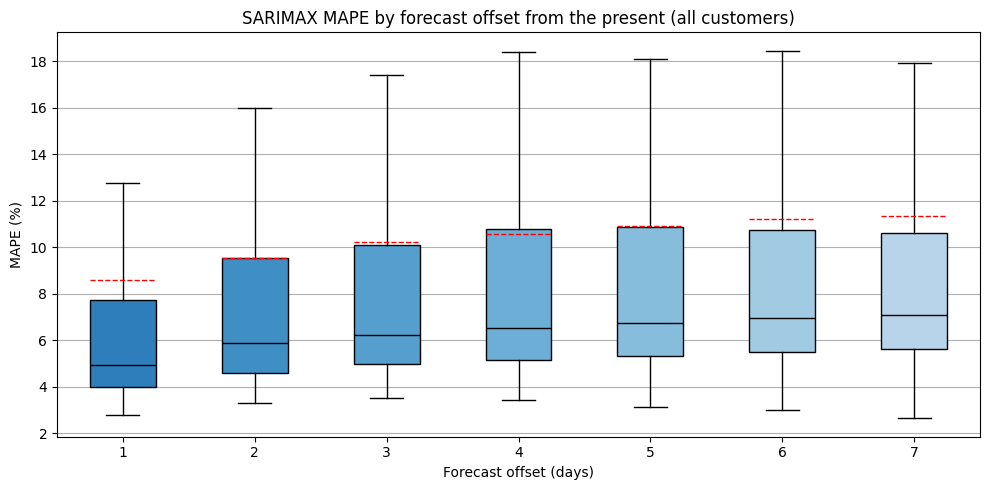

In [119]:
fig, ax = plt.subplots(figsize=(10,5))

colors = cm.Blues(np.linspace(0.7, 0.3, len(mapes_df.columns)))

box = ax.boxplot(
    [mapes_df[forecast_offset] * 100 for forecast_offset in mapes_df.columns],
    vert=True,
    showfliers=False,
    meanline=True,
    showmeans=True,
    patch_artist=True,  # Allow coloring of the boxes
    medianprops=dict(color='black'),  # Set the median line color and thickness
    meanprops=dict(color='red')      # Set the mean line color and thickness
)

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

ax.set_title('SARIMAX MAPE by forecast offset from the present (all customers)')
ax.set_xlabel('Forecast offset (days)')
ax.set_ylabel('MAPE (%)')
ax.yaxis.grid(True, which='both')

plt.tight_layout()
plt.show()

In [65]:
mapes_df.groupby(by='cluster').describe().T

cluster           1          2          3         4
1 count  179.000000  23.000000  57.000000  5.000000
  mean     0.070089   0.170506   0.095921  0.144723
  std      0.075986   0.225759   0.136325  0.056000
  min      0.027953   0.033101   0.039033  0.085510
  25%      0.037536   0.050887   0.053148  0.125368
  50%      0.042912   0.077162   0.064115  0.127496
  75%      0.062669   0.159007   0.081469  0.149155
  max      0.539282   0.999812   0.828116  0.236084
2 count  179.000000  23.000000  57.000000  5.000000
  mean     0.075898   0.194819   0.110987  0.155967
  std      0.069564   0.226577   0.150895  0.058748
  min      0.032773   0.039621   0.043467  0.098539
  25%      0.043092   0.061042   0.063608  0.126316
  50%      0.050882   0.099997   0.073011  0.142304
  75%      0.069234   0.236306   0.097064  0.159612
  max      0.542357   0.999837   0.921759  0.253066
3 count  179.000000  23.000000  57.000000  5.000000
  mean     0.081165   0.211086   0.118638  0.157476
  std      0.073346   0.234305   0.156771  0.059290
  min      0.035128   0.043426   0.047364  0.100187
  25%      0.045901   0.065238   0.069429  0.129067
  50%      0.053956   0.110527   0.078959  0.144622
  75%      0.073555   0.259451   0.105735  0.156999
  max      0.569581   0.999839   0.984684  0.256505
4 count  179.000000  23.000000  57.000000  5.000000
  mean     0.084777   0.221410   0.120653  0.158575
  std      0.074983   0.236847   0.144974  0.061998
  min      0.034396   0.046668   0.050050  0.099217
  25%      0.049143   0.068857   0.073026  0.127814
  50%      0.057448   0.115075   0.083763  0.147015
  75%      0.077306   0.298179   0.112618  0.156488
  max      0.598046   0.999843   0.881299  0.262340
5 count  179.000000  23.000000  57.000000  5.000000
  mean     0.086608   0.232966   0.125149  0.159386
  std      0.080671   0.249140   0.149947  0.062410
  min      0.031414   0.049528   0.053218  0.099400
  25%      0.049598   0.072566   0.075071  0.128614
  50%      0.058564   0.119633   0.088666  0.147596
  75%      0.080164   0.313782   0.110775  0.157566
  max      0.606462   0.999839   0.914882  0.263754
6 count  179.000000  23.000000  57.000000  5.000000
  mean     0.088219   0.242652   0.129768  0.159880
  std      0.081304   0.262027   0.156859  0.062023
  min      0.029973   0.052043   0.056579  0.100029
  25%      0.050982   0.072606   0.075751  0.128969
  50%      0.060409   0.119860   0.093053  0.148604
  75%      0.082190   0.323491   0.116866  0.158380
  max      0.588908   0.999846   0.963888  0.263420
7 count  179.000000  23.000000  57.000000  5.000000
  mean     0.088174   0.250375   0.132798  0.159752
  std      0.081730   0.268058   0.161442  0.062175
  min      0.026365   0.054177   0.057238  0.099446
  25%      0.051478   0.073207   0.078199  0.128964
  50%      0.061065   0.121335   0.093523  0.148219
  75%      0.080725   0.339018   0.121753  0.158724
  max      0.621148   0.999840   0.987496  0.263406

In [73]:
mapes_df

1         2         3         4         5         6  \
cluster customer                                                               
1       MT_091    0.102429  0.103196  0.111932  0.120132  0.108963  0.119932   
        MT_100    0.101227  0.117202  0.129468  0.138962  0.146407  0.149799   
        MT_101    0.039943  0.046853  0.052134  0.056318  0.060161  0.062328   
        MT_104    0.049379  0.061019  0.066754  0.074609  0.082766  0.088396   
        MT_137    0.114155  0.112324  0.125861  0.128365  0.106544  0.104649   
...                    ...       ...       ...       ...       ...       ...   
4       MT_014    0.085510  0.098539  0.100187  0.099217  0.099400  0.100029   
        MT_077    0.127496  0.142304  0.144622  0.147015  0.147596  0.148604   
        MT_095    0.236084  0.253066  0.256505  0.262340  0.263754  0.263420   
        MT_096    0.149155  0.159612  0.156999  0.156488  0.157566  0.158380   
        MT_164    0.125368  0.126316  0.129067  0.127814  0.128614  0.128969   

                         7  
cluster customer            
1       MT_091    0.111649  
        MT_100    0.149796  
        MT_101    0.063736  
        MT_104    0.092170  
        MT_137    0.071608  
...                    ...  
4       MT_014    0.099446  
        MT_077    0.148219  
        MT_095    0.263406  
        MT_096    0.158724  
        MT_164    0.128964  

[264 rows x 7 columns]

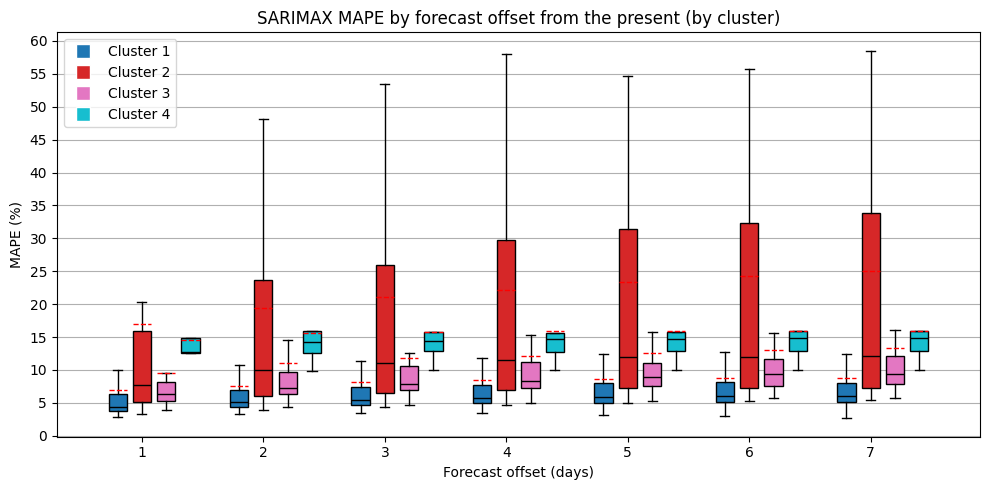

In [118]:
fig, ax = plt.subplots(figsize=(10,5))

clusters = mapes_df.groupby(by='cluster')

num_clusters = len(clusters)

colors = plt.cm.tab10(np.linspace(0, 1, num_clusters))

offsets = len(mapes_df.columns)

space = 0.20

box_width = 0.15

legend_handles = []
legend_labels = []

for (cluster, df), color in zip(clusters, colors):
    box = ax.boxplot(
        [df[forecast_offset] * 100 for forecast_offset in df.columns],
        positions=np.arange(offsets) + ((cluster - num_clusters // 2) * space),
        widths=box_width,
        vert=True,
        showfliers=False,
        meanline=True,
        showmeans=True,
        patch_artist=True,  # Allow coloring of the boxes
        medianprops=dict(color='black'),  # Set the median line color and thickness
        meanprops=dict(color='red')      # Set the mean line color and thickness
    )
    for patch in box['boxes']:
        patch.set_facecolor(color)
    legend_handles.append(Line2D([0], [0], marker='s', color='w', markerfacecolor=color, markersize=10))
    legend_labels.append(f'Cluster {cluster}')

ax.legend(legend_handles, legend_labels, loc='upper left', fontsize=10)

ax.set_xticks(np.arange(offsets))
ax.set_xticklabels(range(1, offsets + 1))

ax.set_yticks(np.arange(0, 65, 5))

ax.set_title('SARIMAX MAPE by forecast offset from the present (by cluster)')
ax.set_xlabel('Forecast offset (days)')
ax.set_ylabel('MAPE (%)')
ax.yaxis.grid(True, which='both')

plt.tight_layout()
plt.show()

In [127]:
mapes_df.loc[mapes_df[1].groupby('cluster').idxmin()]

,,1,2,3,4,5,6,7
cluster,customer,,,,,,,
1,MT_147,0.027953,0.032802,0.035134,0.035410,0.032342,0.031187,0.029142
2,MT_272,0.033101,0.039621,0.043426,0.046668,0.049528,0.052043,0.054177
3,MT_017,0.039033,0.043467,0.047364,0.050050,0.053218,0.056579,0.057238
4,MT_014,0.085510,0.098539,0.100187,0.099217,0.099400,0.100029,0.099446


In [267]:
mapes_df.loc[mapes_df[1].groupby('cluster').idxmax()]

,,1,2,3,4,5,6,7
cluster,customer,,,,,,,
1,MT_175,0.539282,0.542357,0.569581,0.598046,0.606462,0.588908,0.621148
2,MT_086,0.999812,0.999837,0.999839,0.999843,0.999839,0.999846,0.999840
3,MT_334,0.828116,0.921759,0.984684,0.881299,0.914882,0.963888,0.987496
4,MT_095,0.236084,0.253066,0.256505,0.262340,0.263754,0.263420,0.263406


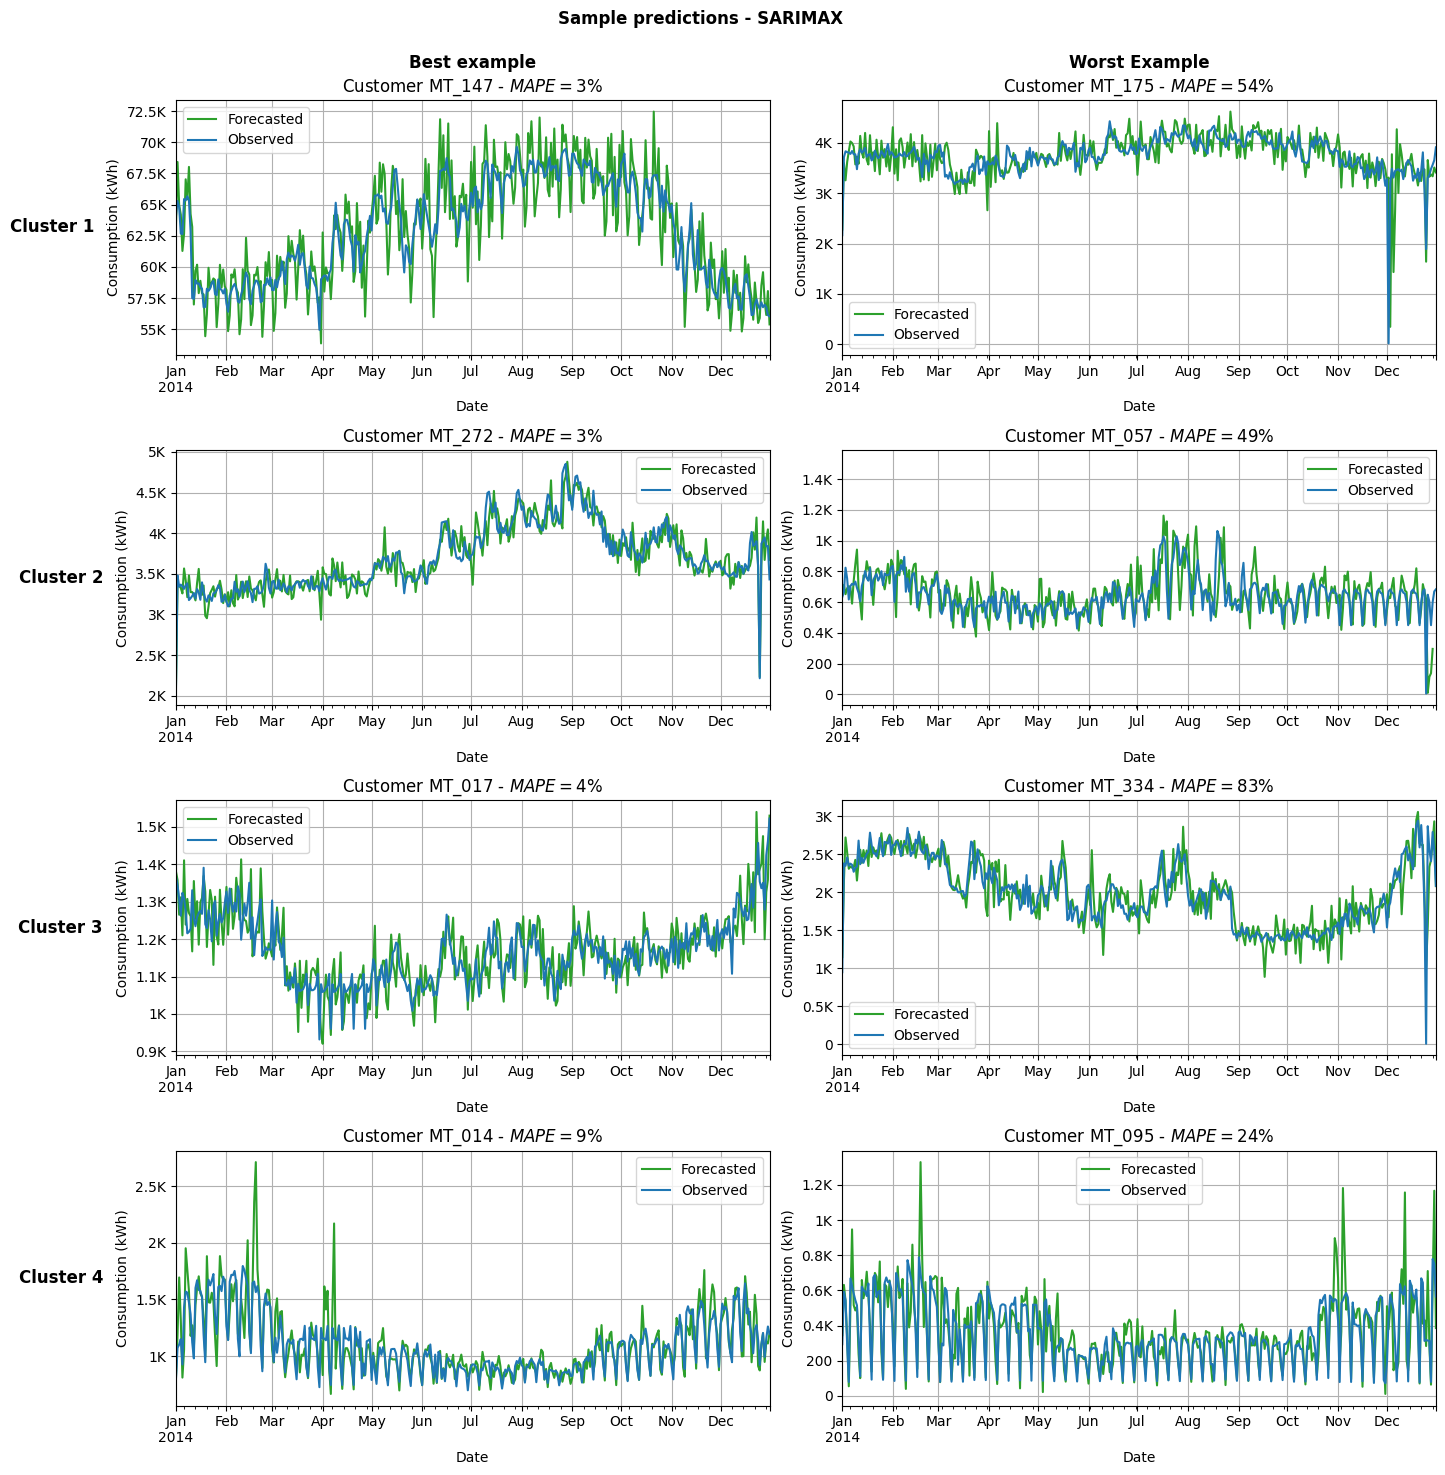

In [266]:
one_day_forecasts_df = forescasts_df[1].sort_index()

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(15,15))

fig.suptitle('Sample predictions - SARIMAX', fontweight='bold')

customers_to_plot = [
    ('MT_147', 'MT_175'),
    ('MT_272', 'MT_057'),
    ('MT_017', 'MT_334'),
    ('MT_014', 'MT_095'),
]

cutoff_date = pd.to_datetime('2014-01-01')

for i, (ax, (c1, c2), cluster_df) in enumerate(zip(axs, customers_to_plot, cluster_dfs), start=1):
    cluster_df = cluster_df[cluster_df.index >= cutoff_date]
    
    observed_c1 = cluster_df[c1]
    observed_c2 = cluster_df[c2]
    
    forecasted_c1 = one_day_forecasts_df.loc[(i, c1)]
    forecasted_c2 = one_day_forecasts_df.loc[(i, c2)]
    
    mape_c1 = mapes_df.loc[(i, c1)][1] * 100
    mape_c2 = mapes_df.loc[(i, c2)][1] * 100

    forecasted_c1.plot(ax=ax[0], color='tab:green', label='Forecasted')
    observed_c1.plot(ax=ax[0], color='tab:blue', label='Observed')

    forecasted_c2.plot(ax=ax[1], color='tab:green', label='Forecasted')
    observed_c2.plot(ax=ax[1], color='tab:blue', label='Observed')

    make_axes_human_readable(ax[0])
    ax[0].set_title(f'Customer {c1} - $MAPE = {mape_c1:.0f}\%$')
    ax[0].set_xlabel('Date')
    ax[0].set_ylabel('Consumption (kWh)')
    ax[0].grid(True, which='major')
    ax[0].legend()
    
    make_axes_human_readable(ax[1])
    ax[1].set_title(f'Customer {c2} - $MAPE = {mape_c2:.0f}\%$')
    ax[1].set_xlabel('Date')
    ax[1].set_ylabel('Consumption (kWh)')
    ax[1].grid(True, which='major')
    ax[1].legend()

pad = 5

for i, ax in enumerate(axs[0], start=1):
    label = 'Best example' if i == 1 else 'Worst Example'
    ax.annotate(label, xy=(0.5, 1.1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline', fontweight='bold')

for i, ax in enumerate(axs[:,0], start=1):
    ax.annotate(f'Cluster {i}', xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center', fontweight='bold')

plt.tight_layout()
fig.subplots_adjust(left=0.15, top=0.92)
plt.show()

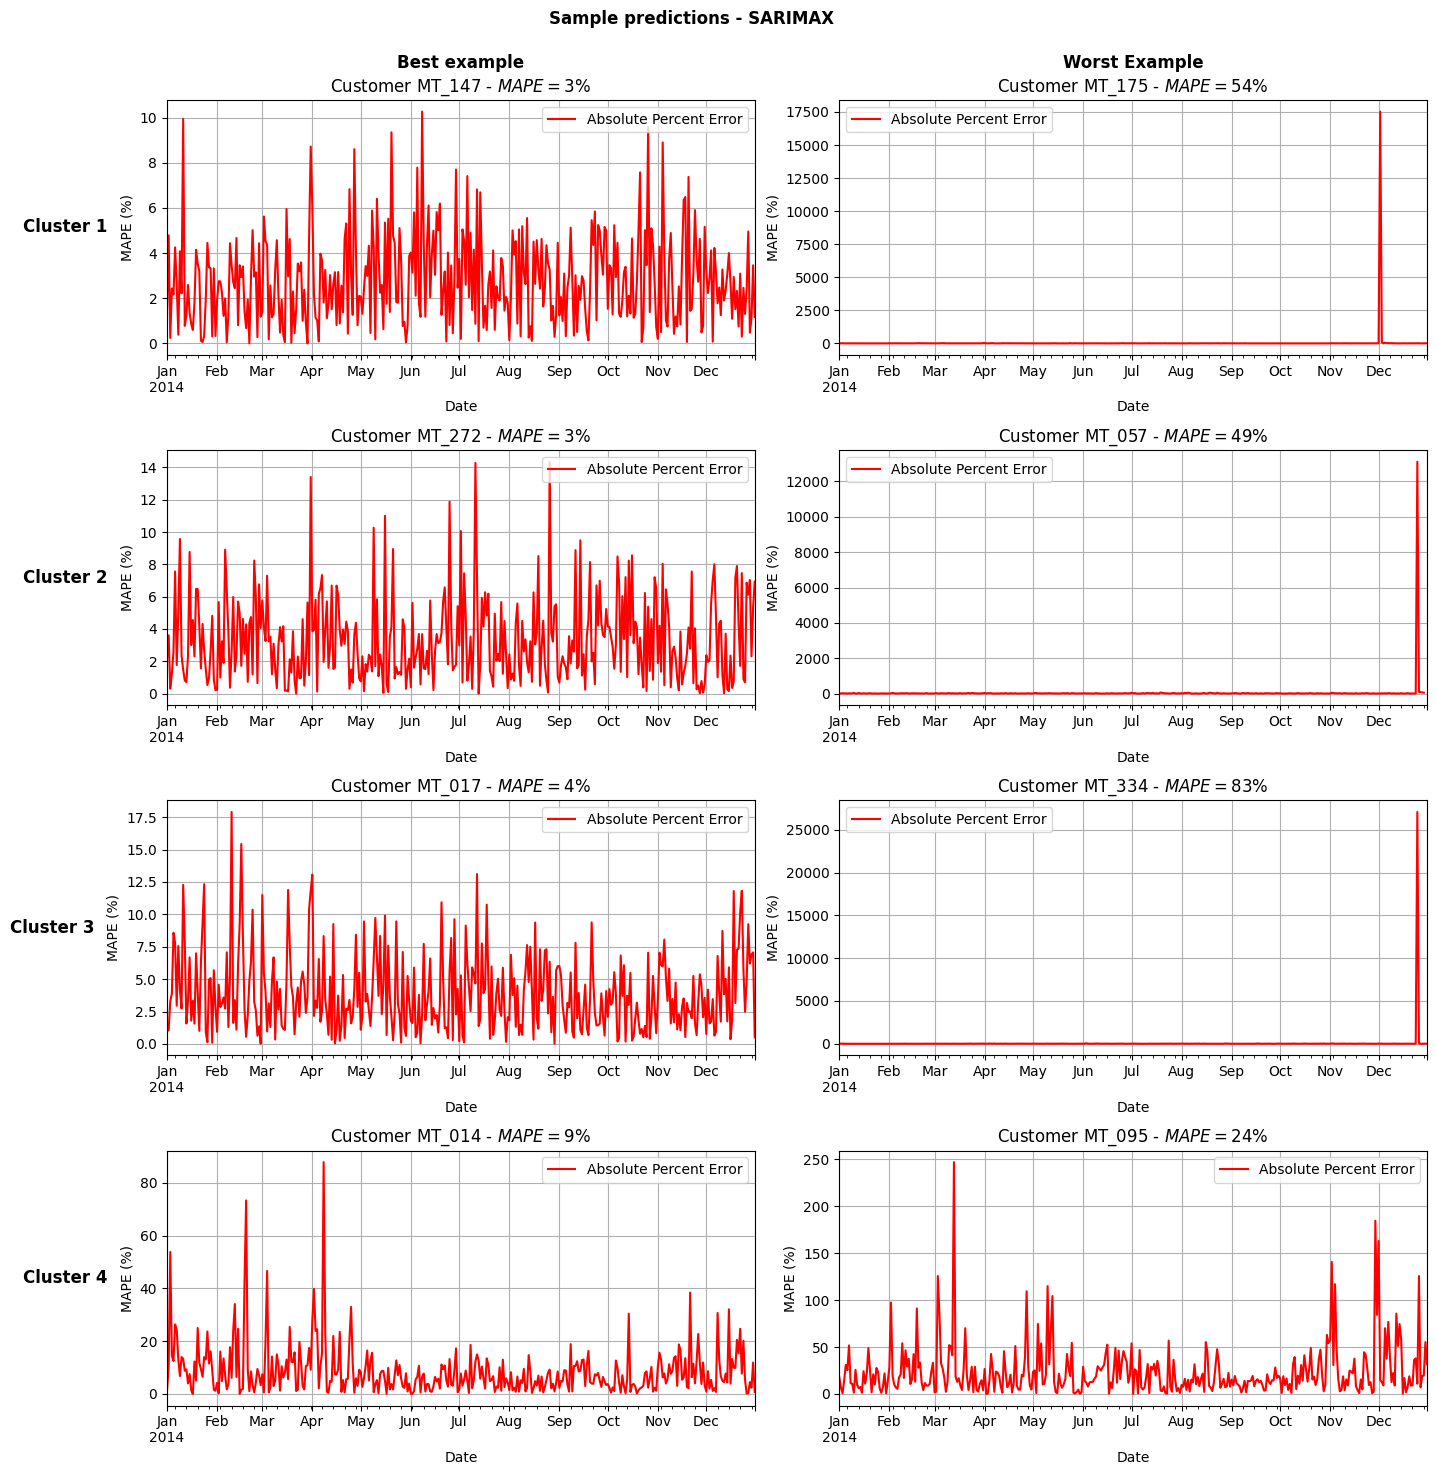

In [272]:
one_day_forecasts_df = forescasts_df[1].sort_index()

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(15,15))

fig.suptitle('Sample predictions - SARIMAX', fontweight='bold')

customers_to_plot = [
    ('MT_147', 'MT_175'),
    ('MT_272', 'MT_057'),
    ('MT_017', 'MT_334'),
    ('MT_014', 'MT_095'),
]

cutoff_date = pd.to_datetime('2014-01-01')

for i, (ax, (c1, c2), cluster_df) in enumerate(zip(axs, customers_to_plot, cluster_dfs), start=1):
    cluster_df = cluster_df[cluster_df.index >= cutoff_date]
    
    observed_c1 = cluster_df[c1]
    observed_c2 = cluster_df[c2]
    
    forecasted_c1 = one_day_forecasts_df.loc[(i, c1)]
    forecasted_c2 = one_day_forecasts_df.loc[(i, c2)]
    
    mape_c1 = mapes_df.loc[(i, c1)][1] * 100
    mape_c2 = mapes_df.loc[(i, c2)][1] * 100

    ape_c1 = pd.Series(
        np.abs((forecasted_c1 - observed_c1) / observed_c1),
        index=observed_c1.index
    ) * 100
    ape_c2 = pd.Series(
        np.abs((forecasted_c2 - observed_c2) / observed_c2),
        index=observed_c2.index
    ) * 100

    ape_c1.plot(ax=ax[0], color='red', label='Absolute Percent Error')

    ape_c2.plot(ax=ax[1], color='red', label='Absolute Percent Error')

    ax[0].set_title(f'Customer {c1} - $MAPE = {mape_c1:.0f}\%$')
    ax[0].set_xlabel('Date')
    ax[0].set_ylabel('MAPE (%)')
    ax[0].grid(True, which='major')
    ax[0].legend()
    
    ax[1].set_title(f'Customer {c2} - $MAPE = {mape_c2:.0f}\%$')
    ax[1].set_xlabel('Date')
    ax[1].set_ylabel('MAPE (%)')
    ax[1].grid(True, which='major')
    ax[1].legend()

pad = 5

for i, ax in enumerate(axs[0], start=1):
    label = 'Best example' if i == 1 else 'Worst Example'
    ax.annotate(label, xy=(0.5, 1.1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline', fontweight='bold')

for i, ax in enumerate(axs[:,0], start=1):
    ax.annotate(f'Cluster {i}', xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center', fontweight='bold')

plt.tight_layout()
fig.subplots_adjust(left=0.15, top=0.92)
plt.show()

## Investigation

In [230]:
forescasts_df.loc[(2, 'MT_086')][1]

/var/folders/lw/xtj0hj3d0_53y1vg5stnhm880000gn/T/ipykernel_1011/1292616237.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  forescasts_df.loc[(2, 'MT_086')][1]


date
2014-01-01         NaN
2014-01-02         NaN
2014-01-03    2.009572
2014-01-04    2.558900
2014-01-05    3.623048
                ...   
2014-12-27    2.512348
2014-12-28         NaN
2014-12-29    1.544078
2014-12-30         NaN
2014-12-31    1.995057
Name: 1, Length: 365, dtype: float64

In [236]:
mapes_df[1].loc[2,:].sort_values(ascending=False)

customer
MT_086    0.999812
MT_057    0.491355
MT_174    0.480211
MT_143    0.387180
MT_007    0.202959
MT_142    0.159614
MT_079    0.158401
MT_119    0.107582
MT_073    0.101437
MT_138    0.093759
MT_141    0.082393
MT_051    0.077162
MT_102    0.075882
MT_118    0.075492
MT_316    0.070772
MT_125    0.063494
MT_002    0.056813
MT_176    0.044961
MT_241    0.042879
MT_226    0.041569
MT_082    0.039780
MT_169    0.035037
MT_272    0.033101
Name: 1, dtype: float64

In [199]:
cluster_model = cluster_models[1]

customer_consumption = cluster_dfs[1]['MT_086'].sort_index()
training_data = customer_consumption[customer_consumption.index < cutoff_date]
test_data = customer_consumption[customer_consumption.index >= cutoff_date]

selected_explanatory_vars = explanatory_variables_df[[
    'heating_degree_days',
    'cooling_degree_days',
    'precip',
    'is_weekend'
]]

exog_training = selected_explanatory_vars.loc[training_data.index]
exog_test = selected_explanatory_vars.loc[test_data.index]

# get_customer_predictions_and_mape(
#     cluster_model,
#     training_data,
#     exog_training,
#     test_data,
#     exog_test
# )

In [200]:
 scaler = StandardScaler()
    
boxcox_training_data, lam = boxcox(training_data)
scaled_training_data = pd.Series(
    scaler.fit_transform(boxcox_training_data.reshape(-1,1)).flatten(),
    index=training_data.index,
    name=training_data.name,
)

boxcox_test_data = boxcox(test_data, lmbda=lam)
scaled_test_data = pd.Series(
    scaler.transform(boxcox_test_data.reshape(-1,1)).flatten(),
    index=test_data.index,
    name=test_data.name,
)

<Axes: xlabel='date'>

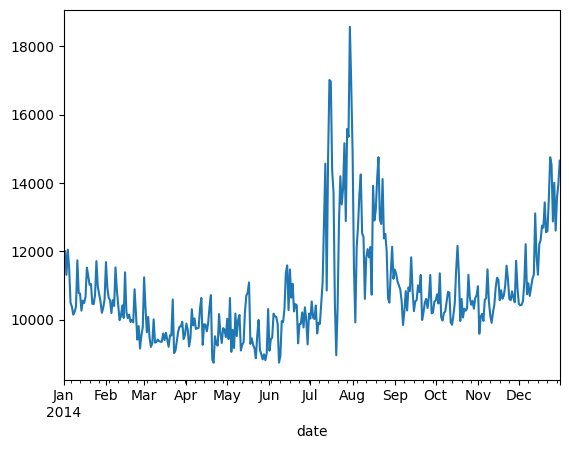

In [204]:
test_data.plot()

<Axes: xlabel='date'>

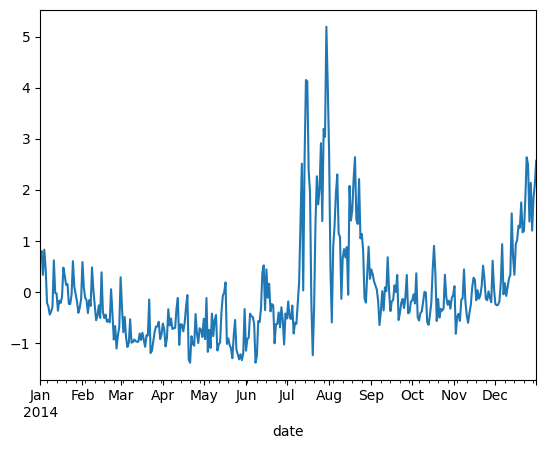

In [220]:
s = scaler.fit_transform(test_data.values.reshape(-1,1)).flatten()
pd.Series(s, index=test_data.index).plot()

<Axes: xlabel='date'>

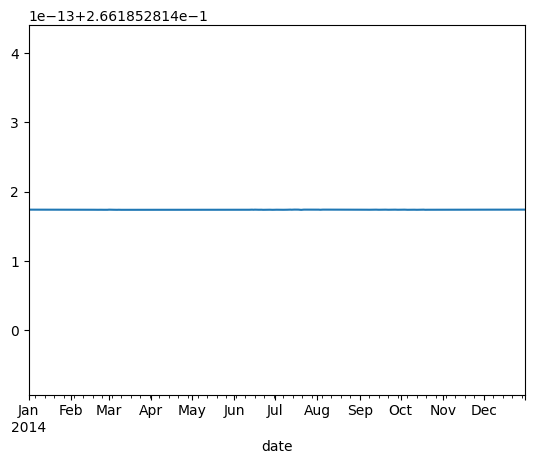

In [205]:
pd.Series(boxcox_test_data, index=test_data.index).plot()

In [211]:
test_data.mean()

10814.772891131941

<Axes: >

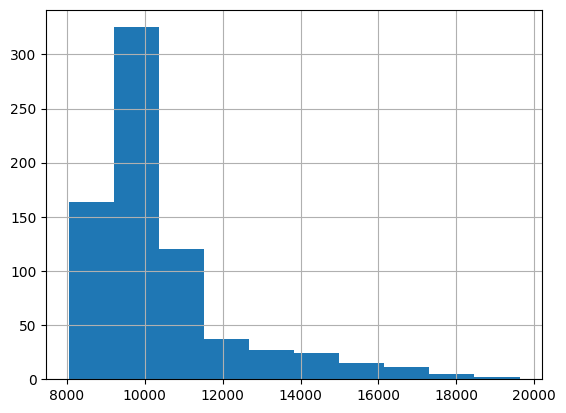

In [212]:
training_data.hist()

In [206]:
boxcox_test_data

array([0.26618528, 0.26618528, 0.26618528, 0.26618528, 0.26618528,
       0.26618528, 0.26618528, 0.26618528, 0.26618528, 0.26618528,
       0.26618528, 0.26618528, 0.26618528, 0.26618528, 0.26618528,
       0.26618528, 0.26618528, 0.26618528, 0.26618528, 0.26618528,
       0.26618528, 0.26618528, 0.26618528, 0.26618528, 0.26618528,
       0.26618528, 0.26618528, 0.26618528, 0.26618528, 0.26618528,
       0.26618528, 0.26618528, 0.26618528, 0.26618528, 0.26618528,
       0.26618528, 0.26618528, 0.26618528, 0.26618528, 0.26618528,
       0.26618528, 0.26618528, 0.26618528, 0.26618528, 0.26618528,
       0.26618528, 0.26618528, 0.26618528, 0.26618528, 0.26618528,
       0.26618528, 0.26618528, 0.26618528, 0.26618528, 0.26618528,
       0.26618528, 0.26618528, 0.26618528, 0.26618528, 0.26618528,
       0.26618528, 0.26618528, 0.26618528, 0.26618528, 0.26618528,
       0.26618528, 0.26618528, 0.26618528, 0.26618528, 0.26618528,
       0.26618528, 0.26618528, 0.26618528, 0.26618528, 0.26618

In [207]:
boxcox(test_data)

(array([0.28917677, 0.28917677, 0.28917677, 0.28917677, 0.28917677,
        0.28917677, 0.28917677, 0.28917677, 0.28917677, 0.28917677,
        0.28917677, 0.28917677, 0.28917677, 0.28917677, 0.28917677,
        0.28917677, 0.28917677, 0.28917677, 0.28917677, 0.28917677,
        0.28917677, 0.28917677, 0.28917677, 0.28917677, 0.28917677,
        0.28917677, 0.28917677, 0.28917677, 0.28917677, 0.28917677,
        0.28917677, 0.28917677, 0.28917677, 0.28917677, 0.28917677,
        0.28917677, 0.28917677, 0.28917677, 0.28917677, 0.28917677,
        0.28917677, 0.28917677, 0.28917677, 0.28917677, 0.28917677,
        0.28917677, 0.28917677, 0.28917677, 0.28917677, 0.28917677,
        0.28917677, 0.28917677, 0.28917677, 0.28917677, 0.28917677,
        0.28917677, 0.28917677, 0.28917677, 0.28917677, 0.28917677,
        0.28917677, 0.28917677, 0.28917677, 0.28917677, 0.28917677,
        0.28917677, 0.28917677, 0.28917677, 0.28917677, 0.28917677,
        0.28917677, 0.28917677, 0.28917677, 0.28

In [198]:
exog_test

,heating_degree_days,cooling_degree_days,precip,is_weekend
date,,,,
2014-01-01,5.452926,0.0,0.089,0
2014-01-02,3.990161,0.0,0.083,0
2014-01-03,5.410022,0.0,0.348,0
2014-01-04,7.687619,0.0,0.584,1
2014-01-05,6.614942,0.0,0.000,1
...,...,...,...,...
2014-12-27,9.032632,0.0,0.000,1
2014-12-28,7.697900,0.0,0.000,1
2014-12-29,10.921202,0.0,0.000,0
